# Imports

In [94]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
%matplotlib inline

from datetime import datetime
import time

import plotly.plotly as py
import plotly.graph_objs as go

## Load file with 2016 results
Use the Bib number as the index (every athlete has a different number)

In [2]:
df = pd.read_csv('marathon_results_2016.csv', index_col='Bib')

Make all times, timedeltas

In [3]:
df.iloc[:, 8:20] = df.iloc[:, 8:20].apply(pd.to_timedelta)

In [4]:
df.describe()

,Age,5K,10K,15K,20K,Half,25K,30K,35K,40K,Pace,Proj Time,Official Time,Overall,Gender,Division
count,26630.000000,26630,26630,26630,26630,26630,26630,26630,26630,26630,26630,26630,26630,26630.000000,26630.000000,26630.000000
mean,42.514044,0 days 00:25:13.795230,0 days 00:50:45.694517,0 days 01:16:47.236162,0 days 01:43:37.357942,0 days 01:49:25.497070,0 days 02:11:14.040593,0 days 02:40:30.724108,0 days 03:11:22.588997,0 days 03:41:49.984829,0 days 00:08:58.375291,0 days 03:54:12.342470,0 days 03:55:02.581411,13314.764176,6707.085242,1613.305896
std,11.347955,0 days 00:04:02.180705,0 days 00:08:09.035094,0 days 00:12:25.017872,0 days 00:17:13.064890,0 days 00:18:06.943013,0 days 00:22:09.252135,0 days 00:28:06.900602,0 days 00:33:43.807474,0 days 00:39:13.302840,0 days 00:01:34.084447,0 days 00:43:41.004606,0 days 00:41:06.428816,7687.226481,3928.246611,1443.420260
min,18.000000,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:05:04,0 days 00:00:00,0 days 02:12:45,1.000000,1.000000,1.000000
25%,34.000000,0 days 00:22:25,0 days 00:45:02,0 days 01:07:58.250000,0 days 01:31:42,0 days 01:36:51,0 days 01:55:54,0 days 02:21:23,0 days 02:48:10,0 days 03:14:50.250000,0 days 00:07:53,0 days 03:26:17.250000,0 days 03:26:26,6658.250000,3329.000000,510.000000
50%,43.000000,0 days 00:24:47,0 days 00:49:44,0 days 01:15:09,0 days 01:41:20,0 days 01:47:00,0 days 02:07:55,0 days 02:36:10,0 days 03:05:45,0 days 03:35:13,0 days 00:08:42,0 days 03:48:01,0 days 03:48:05,13314.500000,6657.500000,1180.000000
75%,51.000000,0 days 00:27:21,0 days 00:55:02,0 days 01:23:15.750000,0 days 01:52:16,0 days 01:58:32,0 days 02:22:16,0 days 02:54:26,0 days 03:28:34,0 days 04:02:20,0 days 00:09:48,0 days 04:16:41.750000,0 days 04:16:43,19971.750000,9986.000000,2198.000000
max,83.000000,0 days 00:55:50,0 days 01:35:31,0 days 02:40:58,0 days 04:29:40,0 days 04:47:17,0 days 04:27:33,0 days 07:36:38,0 days 06:49:51,0 days 07:59:12,0 days 00:24:30,0 days 10:42:16,0 days 10:30:23,26629.000000,14463.000000,5946.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 26630 entries, 5 to 28487
Data columns (total 23 columns):
Name             26630 non-null object
Age              26630 non-null int64
M/F              26630 non-null object
City             26629 non-null object
State            23783 non-null object
Country          26630 non-null object
Citizen          1122 non-null object
Unnamed: 8       83 non-null object
5K               26630 non-null timedelta64[ns]
10K              26630 non-null timedelta64[ns]
15K              26630 non-null timedelta64[ns]
20K              26630 non-null timedelta64[ns]
Half             26630 non-null timedelta64[ns]
25K              26630 non-null timedelta64[ns]
30K              26630 non-null timedelta64[ns]
35K              26630 non-null timedelta64[ns]
40K              26630 non-null timedelta64[ns]
Pace             26630 non-null timedelta64[ns]
Proj Time        26630 non-null timedelta64[ns]
Official Time    26630 non-null timedelta64[ns]
Overall      

## Finishers by age

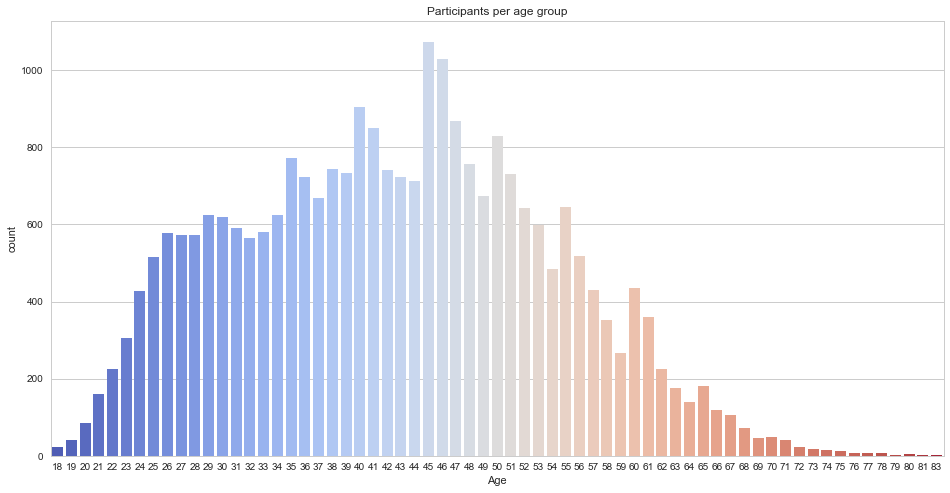

In [6]:
g = sns.countplot('Age', data=df, palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Participants per age group")


### Finishers by age and gender

In [93]:
x0=df['Age'][df['M/F']=='M']
x1=df['Age'][df['M/F']=='F']

trace2 = go.Histogram(x=x0, opacity=0.75, name='Male')
trace3 = go.Histogram(x=x1, opacity=0.75, name='Female', marker=dict(color='#F64E8B'))

data=[trace2, trace3]
layout = go.Layout(barmode='overlay',
                   title='Age Distribution by Gender',
                   xaxis=dict(title='Age'),
                   yaxis=dict(title='Count'),
                   bargap=0.2)
fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='overlaid histogram')

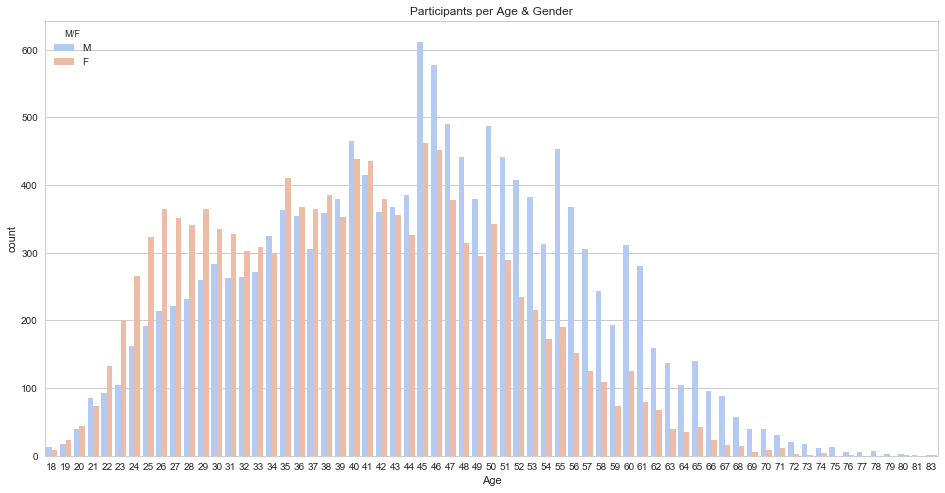

In [7]:
g = sns.countplot('Age', data=df, palette="coolwarm", hue='M/F')
g.figure.set_size_inches(16,8)
g.set_title("Participants per Age & Gender")

## Boxplot by age and gender

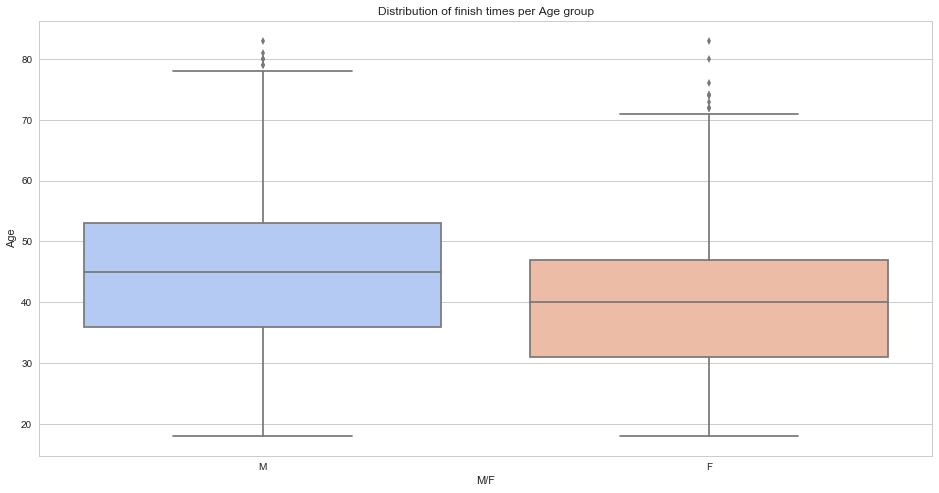

In [8]:
g = sns.boxplot(df['M/F'], df['Age'], palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Distribution of finish times per Age group")

### Distribution of official times by age
Official Time is transformed into a float to chart times.

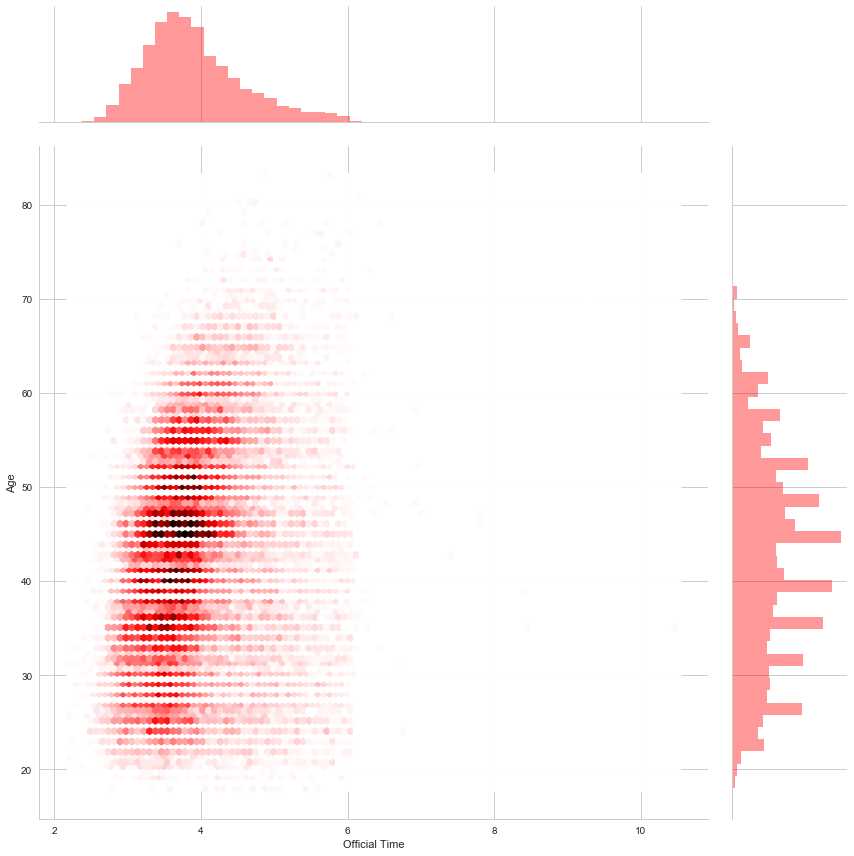

In [9]:
g = sns.jointplot( x=df['Official Time'].apply(lambda x: x.total_seconds()/3600), y=df['Age'], stat_func=None, kind='hex', color="r", size=12)

### Boxplot of finishing times by age

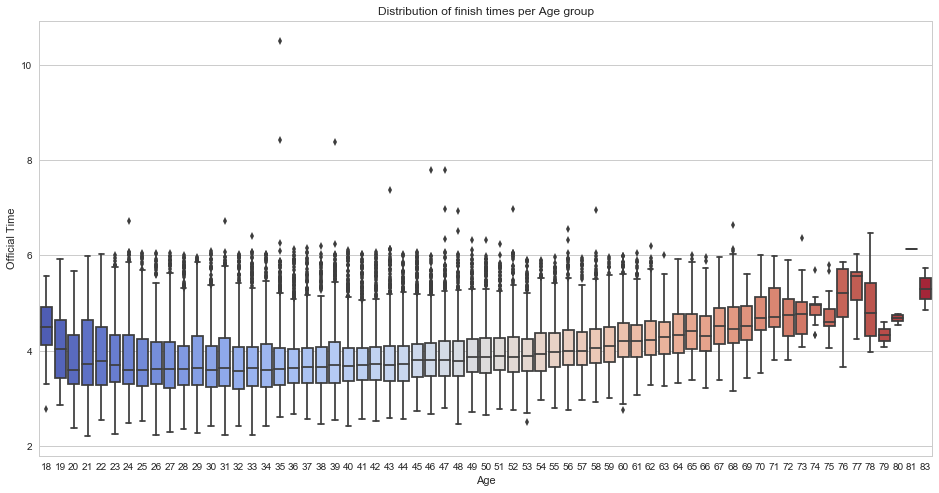

In [10]:
g = sns.boxplot(x='Age', y=df['Official Time'].apply(lambda x: x.total_seconds()/3600), data=df, palette="coolwarm")
g.figure.set_size_inches(16,8)
g.set_title("Distribution of finish times per Age group")


### Overall placement by age and gender - probably useless...

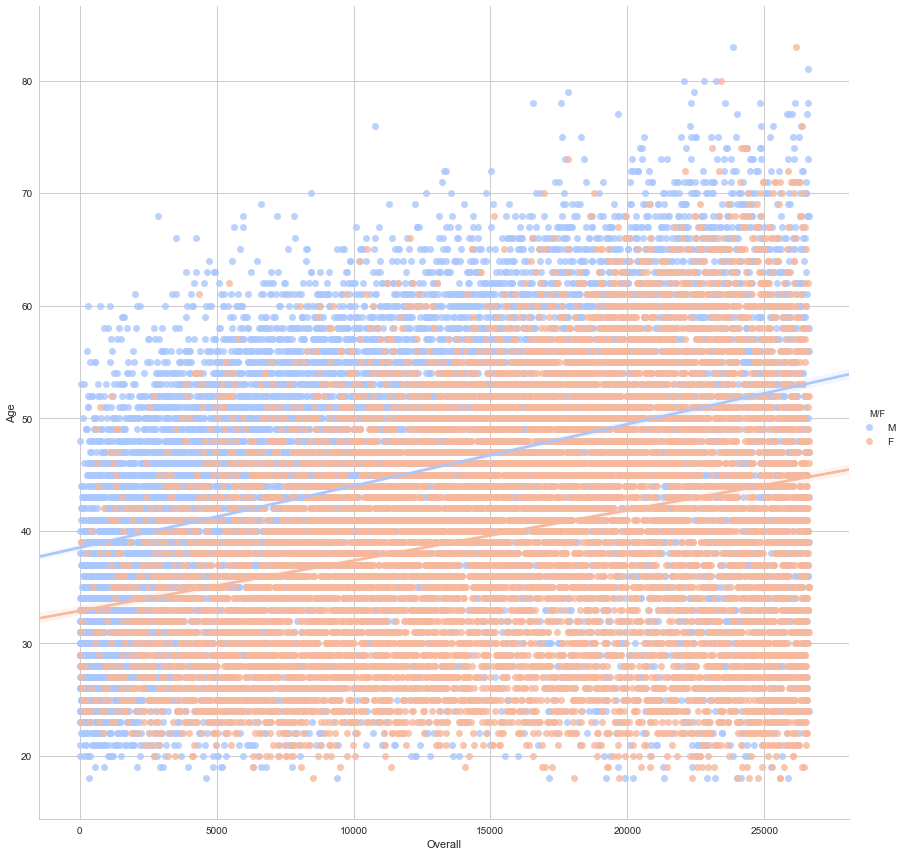

In [11]:
g = sns.lmplot(x='Overall', y='Age', data=df, hue='M/F', palette="coolwarm", size=12)


#### Separate the name column into first and last names

In [12]:
s = df['Name'].apply(lambda x: x.split(', '))
df['First Name'] = s.apply(lambda x: x[1])
df['Last Name'] = s.apply(lambda x: x[0])
df.drop('Name', axis=1, inplace=True)

## Most popular country - finishers

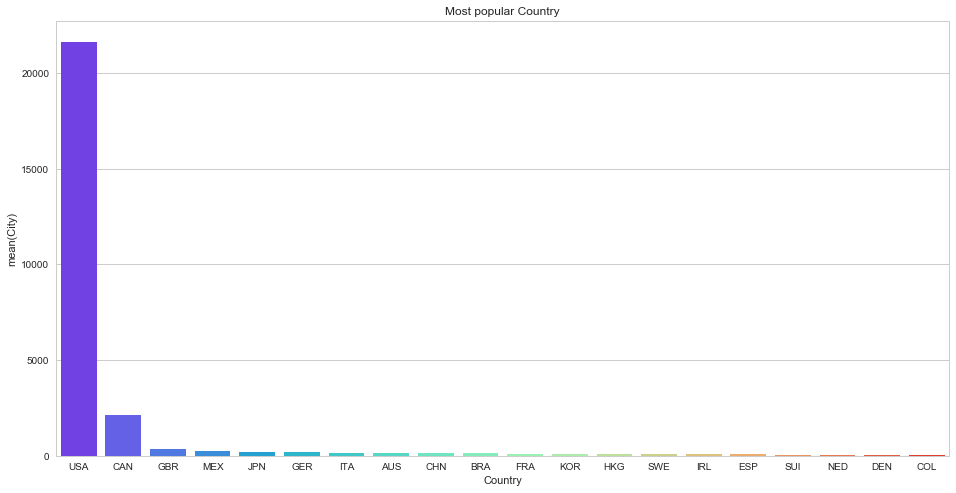

In [13]:
s = df.groupby('Country').count()['City'].sort_values(ascending=False).head(20)
g = sns.barplot(s.index, s, palette='rainbow')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Country")

### Most popular country without USA

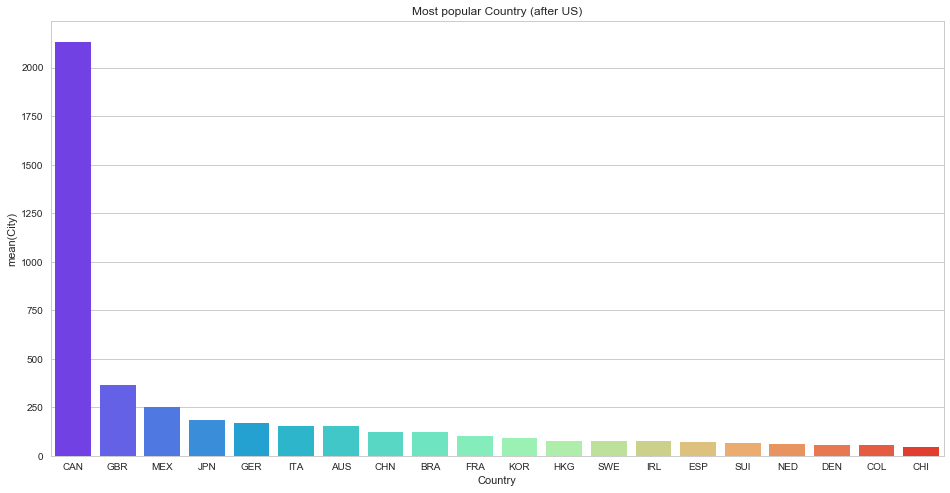

In [14]:
s = df.groupby('Country').count()['City'].sort_values(ascending=False).head(21)[1:]
g = sns.barplot(s.index, s, palette='rainbow')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Country (after US)")

### most popular country without USA and Canada

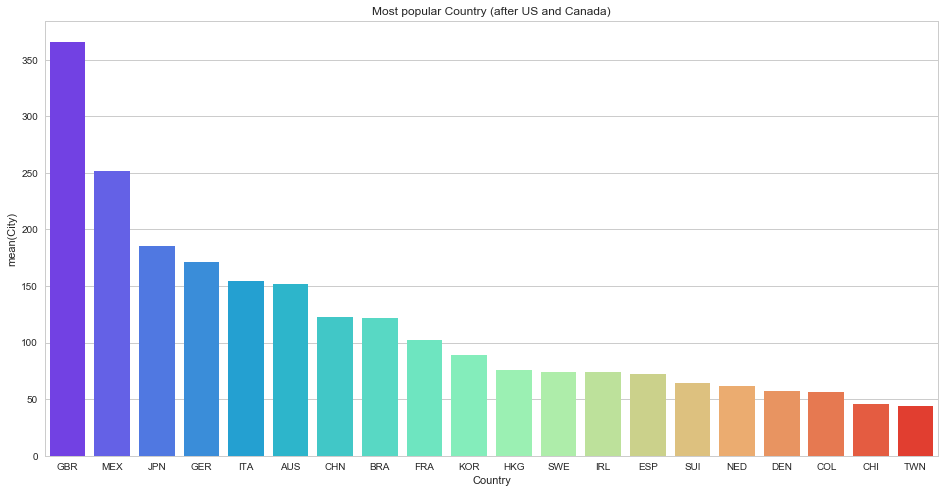

In [15]:
s = df.groupby('Country').count()['City'].sort_values(ascending=False).head(22)[2:]
g = sns.barplot(s.index, s, palette='rainbow')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Country (after US and Canada)")

## Most popular city
required to check that the City is not null (one record has not city and crashes the kernel). Known bug that was supposed to be fixed with version .19 but it's not working here.

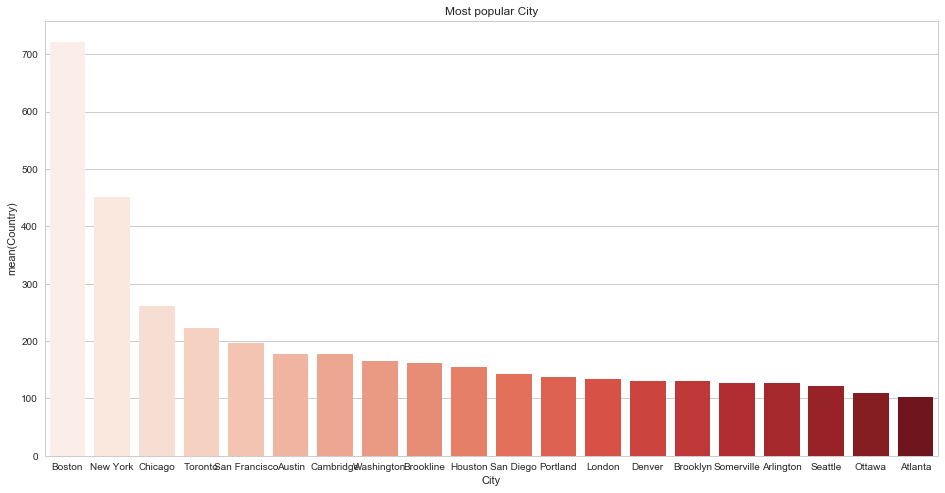

In [16]:
s = df[df['City'].notnull()].groupby('City').count()['Country'].sort_values(ascending=False).head(20)
g = sns.barplot(s.index, s, palette='Reds')
g.figure.set_size_inches(16,8)
g.set_title("Most popular City")

## Most popular state
In the USA, there are some Canadian states that have more participants that some USA states

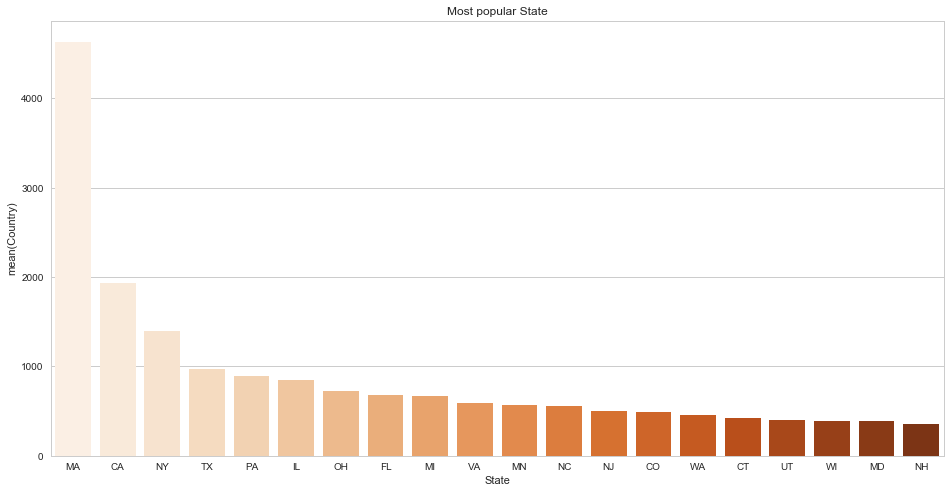

In [17]:
s = df[df['Country'] == 'USA'].groupby('State').count()['Country'].sort_values(ascending=False).head(20)
g = sns.barplot(s.index, s, palette="Oranges")
g.figure.set_size_inches(16,8)
g.set_title("Most popular State")

## Most popular last name

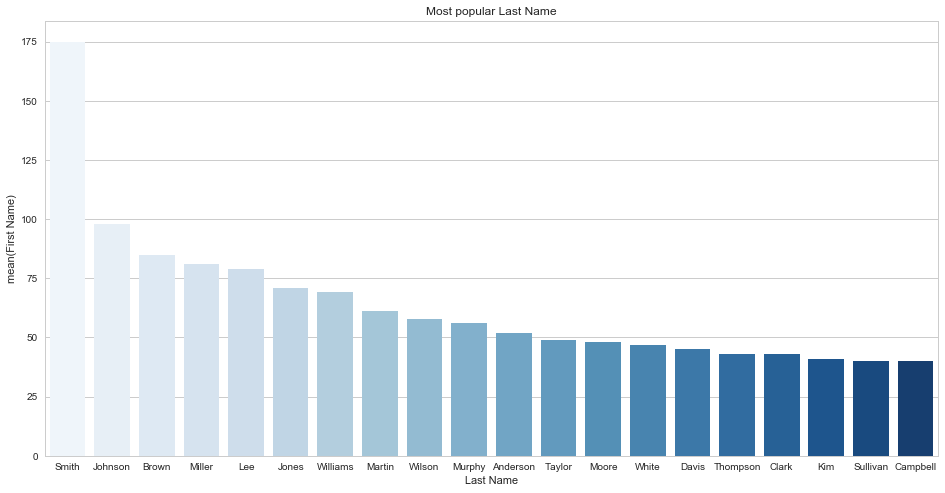

In [18]:
s = df.groupby('Last Name').count()['First Name'].sort_values(ascending=False).head(20)
g = sns.barplot(s.index, s, palette='Blues')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Last Name")

## Most popular first name

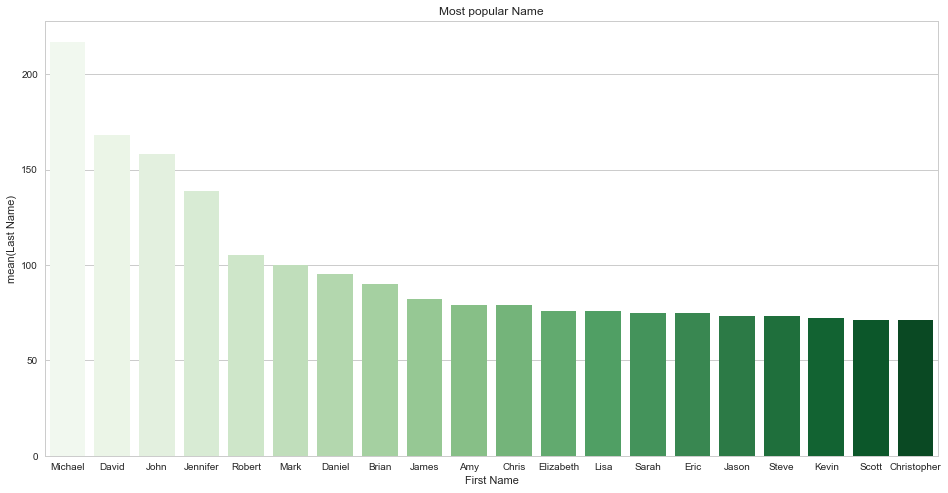

In [19]:
s = df.groupby('First Name').count()['Last Name'].sort_values(ascending=False).head(20)
g = sns.barplot(s.index, s, palette='Greens')
g.figure.set_size_inches(16,8)
g.set_title("Most popular Name")

### Analysis of fist half vs second half...

In [20]:
df['Half_2'] = df['Official Time'] - df['Half']

In [21]:
df['Half'][df['Half'] == '0']

Bib
663     0 days
7513    0 days
8003    0 days
8351    0 days
17345   0 days
11219   0 days
31326   0 days
20590   0 days
19410   0 days
23528   0 days
24087   0 days
21703   0 days
15569   0 days
29415   0 days
31569   0 days
9061    0 days
19881   0 days
Name: Half, dtype: timedelta64[ns]

#### Calculate the difference between the first and second half 

In [22]:
df['2nd_Split'] = (df['Half_2']-df["Half"])

In [23]:
df['2nd_Split']= df['2nd_Split'].apply(lambda x: x.total_seconds()/60)

#### Plot the differences.
The distinct line of points over 150 and up is caused by the records that don't have a half marathon registered (except for the very last that is over 250).

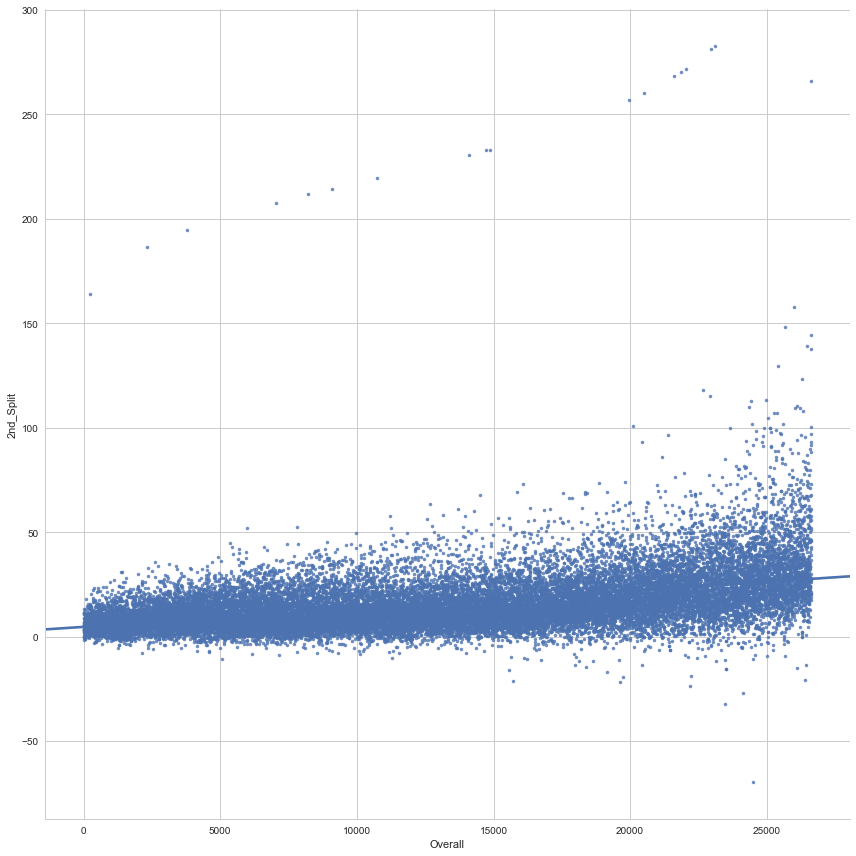

In [24]:
sns.lmplot(data=df, y='2nd_Split', x='Overall', size=12, markers='.')

#### Find the extreme cases of possitive split and negative split

In [25]:
df[df['2nd_Split'] == df['2nd_Split'].max()][['5K', '10K','15K', '20K', '25K', '30K', '35K', '40K']]

,5K,10K,15K,20K,25K,30K,35K,40K
Bib,,,,,,,,
19881,00:25:57,00:53:36,01:30:10,02:01:09,02:35:20,03:14:30,03:53:48,04:28:22


In [26]:
df[df['2nd_Split'] == df['2nd_Split'].max()]

,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,15K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
Bib,,,,,,,,,,,,,,,,,,,,,
19881,41,F,Candiac,QC,CAN,NaN,NaN,00:25:57,00:53:36,01:30:10,...,00:10:47,04:42:39,04:42:39,23092,10198,1695,Nadine,Gilbert,04:42:39,282.65


In [27]:
df[df['2nd_Split'] == df['2nd_Split'].min()][['5K', '10K', '15K', '20K', '25K', '30K', '35K', '40K', 'Division']]

,5K,10K,15K,20K,25K,30K,35K,40K,Division
Bib,,,,,,,,,
6698,00:22:00,00:45:02,01:22:46,02:59:37,03:27:32,03:55:42,04:21:36,04:49:14,4503


In [28]:
df[df['2nd_Split'] == df['2nd_Split'].min()]

,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,15K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
Bib,,,,,,,,,,,,,,,,,,,,,
6698,39,M,Byron Center,MI,USA,NaN,NaN,00:22:00,00:45:02,01:22:46,...,00:11:29,05:00:51,05:00:51,24513,13588,4503,Brian R.,Cunningham,01:55:39,-69.55


#### Find how many negative splits - faster second half than first half. (particularly difficult in Boston due to the Newton Hills)

In [29]:
df[df['2nd_Split'] < 0].sort_values(by='2nd_Split')

,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,15K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
Bib,,,,,,,,,,,,,,,,,,,,,
6698,39,M,Byron Center,MI,USA,NaN,NaN,00:22:00,00:45:02,01:22:46,...,00:11:29,05:00:51,05:00:51,24513,13588,4503,Brian R.,Cunningham,01:55:39,-69.550000
17816,30,F,Denver,CO,USA,NaN,NaN,00:27:34,00:54:31,01:26:53,...,00:10:57,04:46:53,04:46:53,23458,10365,5042,Meaghan E,Mahoney,02:07:25,-32.050000
1566,38,M,Bellevue,WA,USA,NaN,NaN,00:31:04,01:06:21,02:00:13,...,00:11:16,04:55:13,04:55:13,24124,13401,4450,Mathew J.,Hong,02:14:07,-26.983333
19021,40,F,Ogden,UT,USA,NaN,NaN,00:30:38,01:04:06,01:40:30,...,00:10:25,04:33:05,04:33:05,22178,9697,1634,Danielle,Nielsen,02:04:38,-23.816667
5023,29,M,Bowling Green,KY,USA,NaN,NaN,00:31:59,01:06:29,01:41:11,...,00:09:43,04:14:43,04:14:43,19639,11370,3952,David J,Croxton,01:56:27,-21.816667
25031,59,F,Hopkinton,MA,USA,NaN,NaN,00:25:18,00:51:28,01:18:55,...,00:09:01,03:56:00,03:56:00,15702,5943,88,Catherine L,Howe,01:47:18,-21.400000
276,39,M,Kailua,HI,USA,NaN,NaN,00:43:56,01:27:49,02:11:51,...,00:13:30,05:53:42,05:53:42,26399,14371,4772,Michael,Arnstein,02:46:36,-20.500000
26442,23,M,East Boston,MA,USA,NaN,NaN,00:35:14,01:06:38,01:38:39,...,00:09:45,04:15:26,04:15:26,19755,11423,3971,Robert,Durben,01:58:04,-19.300000
16691,58,M,Mesa,AZ,USA,NaN,NaN,00:28:41,01:02:24,01:36:39,...,00:10:27,04:33:47,04:33:47,22244,12514,1332,Jeffrey A,Donnelly,02:07:36,-18.583333


In [30]:
(len(df[df['2nd_Split'] < 0].sort_values(by='2nd_Split'))/len(df))*100

2.5535110777318812

Only 2.55% (680 finishers) of the finishers have a negative split.

#### Find the ones that have identical first half and second half

In [31]:
df[df['2nd_Split']== 0].sort_values(by='2nd_Split')

,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,15K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
Bib,,,,,,,,,,,,,,,,,,,,,
1,26,M,Ambo,NaN,ETH,NaN,NaN,00:15:47,00:31:21,00:47:08,...,00:05:06,02:13:32,02:13:32,2,2,2,Lelisa,Desisa,01:06:46,0.0
7257,46,M,Lakewood,CO,USA,NaN,NaN,00:21:18,00:42:41,01:03:59,...,00:06:52,02:59:38,02:59:38,1398,1317,109,Monte,Merz,01:29:49,0.0
16374,43,F,Seattle,WA,USA,NaN,NaN,00:23:08,00:46:01,01:09:09,...,00:07:35,03:18:36,03:18:36,4622,620,72,Anne,Theisen,01:39:18,0.0
16576,53,F,Sellersburg,IN,USA,NaN,NaN,00:24:15,00:49:04,01:13:48,...,00:07:56,03:27:50,03:27:50,7045,1406,37,Rachel A,Parrella,01:43:55,0.0
19409,39,F,Santa Barbara,CA,USA,NaN,NaN,00:24:51,00:49:23,01:14:07,...,00:07:59,03:28:54,03:28:54,7398,1548,1236,Jennifer,Miller,01:44:27,0.0
20707,43,F,Joppa,MD,USA,NaN,NaN,00:25:51,00:52:08,01:18:35,...,00:08:30,03:42:26,03:42:26,11607,3574,574,Stacey,Esposito,01:51:13,0.0


Only 6 finishers have identical split times (quite rare)

### Calculations of pace at different stages of the race.

#### Fastest pace recorded in every 5K segment
since there are some missing times at some of the 5K markers, we calculate the difference of times between markers
and then we find all the non negative ones.
Then we find the min and print a nice fivek_pace.

In [32]:
def fivek_pace(t):
    minute, second = divmod(t.seconds, 60)
    print('%02d:%02d' % (minute, second))

In [33]:
fivek_pace((df['5K'][df['5K']!='0']/3.1).min())
fivek_pace(((df['10K'] -df['5K'])[(df['10K'] -df['5K'])>'0']/3.1).min())
fivek_pace(((df['15K'] -df['10K'])[(df['15K'] -df['10K'])>'0']/3.1).min())
fivek_pace(((df['20K'] -df['15K'])[(df['20K'] -df['15K'])>'0']/3.1).min())
fivek_pace(((df['25K'] -df['20K'])[(df['25K'] -df['20K'])>'0']/3.1).min())
fivek_pace(((df['30K'] -df['25K'])[(df['30K'] -df['25K'])>'0']/3.1).min())
fivek_pace(((df['35K'] -df['30K'])[(df['35K'] -df['30K'])>'0']/3.1).min())
fivek_pace(((df['40K'] -df['35K'])[(df['40K'] -df['35K'])>'0']/3.1).min())

05:05
04:45
05:05
05:11
05:10
04:50
05:10
05:01


##### This person has not time recorded at any point but the end...?

It is the only one that has all segments missing

In [34]:
df[(df['5K']=='00:00:00') & (df['10K'] == '00:00:00') & (df['15K'] == '00:00:00') & (df['20K'] == '00:00:00') & (df['25K'] == '00:00:00')]

,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,15K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
Bib,,,,,,,,,,,,,,,,,,,,,
7513,43,M,Aurora,ON,CAN,CHN,NaN,0 days,0 days,0 days,...,00:07:08,0 days,03:06:45,2335,2157,336,Wei,Zhang,03:06:45,186.75


## Division winners

In [35]:
win = df[df['Division'] == 1].fillna('')
win

,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,15K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
Bib,,,,,,,,,,,,,,,,,,,,,
5,21,M,Addis Ababa,,ETH,,,00:15:47,00:31:20,00:47:07,...,00:05:04,02:12:45,02:12:45,1,1,1,Lemi Berhanu,Hayle,01:06:00,-0.750000
79,40,M,Boulder,CO,USA,,,00:16:26,00:32:52,00:49:30,...,00:05:32,02:24:55,02:24:55,17,17,1,Clint,Wells,01:14:40,4.416667
75,48,M,Belluno,,ITA,,,00:16:21,00:32:51,00:49:30,...,00:05:38,02:27:41,02:27:41,22,22,1,Said Sr.,Boudalia,01:16:56,6.183333
F6,29,F,Liteshoa,,ETH,,,00:18:22,00:36:21,00:53:59,...,00:05:42,02:29:19,02:29:19,29,1,1,Atsede,Baysa,01:13:47,-1.750000
84,53,M,Vitoria-Gasteiz,,ESP,,,00:17:01,00:34:20,00:51:28,...,00:05:46,02:30:57,02:30:57,37,34,1,Martin,Fiz,01:17:37,4.283333
1658,56,M,Brighton,MA,USA,,,00:19:40,00:38:44,00:58:02,...,00:06:21,02:46:09,02:45:29,283,266,1,Robert,Cipriano,01:23:45,2.016667
806,60,M,Lisle,IL,USA,,,00:18:40,00:37:48,00:57:08,...,00:06:20,02:45:47,02:45:47,286,269,1,Dave,Walters,01:24:47,3.783333
F103,40,F,Encinitas,CA,USA,,,00:19:18,00:38:25,00:57:52,...,00:06:27,02:48:49,02:48:49,413,20,1,Hilary L.,Corno,01:27:04,5.316667
F116,49,F,Brookfield,WI,USA,,,00:19:22,00:39:03,00:58:53,...,00:06:33,02:51:33,02:51:33,592,27,1,Corina,Canitz,01:28:15,4.950000


# Analysis of your's trully

In [36]:
me = df[df['Last Name'] == 'Jourdain']

In [37]:
me

,Age,M/F,City,State,Country,Citizen,Unnamed: 8,5K,10K,15K,...,Pace,Proj Time,Official Time,Overall,Gender,Division,First Name,Last Name,Half_2,2nd_Split
Bib,,,,,,,,,,,,,,,,,,,,,
12418,57,M,Vista,CA,USA,NaN,NaN,00:24:26,00:48:30,01:12:27,...,00:08:18,03:37:31,03:37:31,9998,7240,395,Roberto,Jourdain,01:55:25,13.316667


In [38]:
K5 = ((me['5K'])/3.1).iloc[0].total_seconds()/60
K10 = ((me['10K'] - me['5K'])/3.1).iloc[0].total_seconds()/60
K15 = ((me['15K'] - me['10K'])/3.1).iloc[0].total_seconds()/60
K20 = ((me['20K'] - me['15K'])/3.1).iloc[0].total_seconds()/60
K25 = ((me['25K'] - me['20K'])/3.1).iloc[0].total_seconds()/60
K30 = ((me['30K'] - me['25K'])/3.1).iloc[0].total_seconds()/60
K35 = ((me['35K'] - me['30K'])/3.1).iloc[0].total_seconds()/60
K40 = ((me['40K'] - me['35K'])/3.1).iloc[0].total_seconds()/60

In [39]:
markers = {' 5K':K5, '10K':K10, '15K':K15, '20K':K20, '25K':K25, '30K':K30, '35K':K35, '40K':K40}

In [40]:
run = pd.DataFrame(markers, index=markers.keys())

### Not looking too good at the end

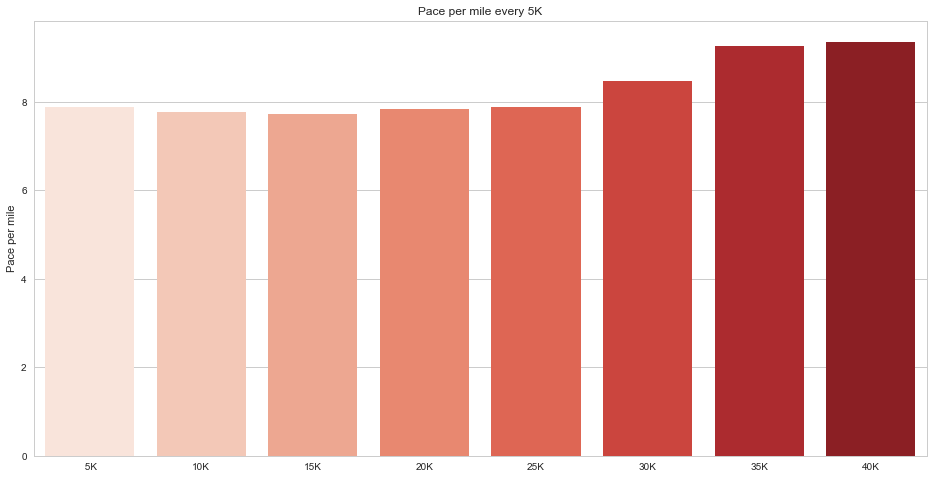

In [41]:
g = sns.barplot(run.columns, run.iloc[0], palette='Reds')
g.figure.set_size_inches(16,8)
g.set_ylabel('Pace per mile')
g.set_title('Pace per mile every 5K')


In [42]:
me.Age

Bib
12418    57
Name: Age, dtype: int64

In [43]:

import plotly.plotly as py
import plotly.graph_objs as go

In [45]:
#sns.lmplot(data=df, y='2nd_Split', x='Overall', size=12, markers='.')
N = 100000
trace = go.Scattergl(
    x = df['Overall'],
    y = df['2nd_Split'],
    mode = 'markers',
    marker = dict(
        color = 'FFBAD2',
        line = dict(width = 1)
    )
)
data = [trace]
py.iplot(data, filename='compare_webgl')
